# GLM example code
### Bernardo AO

## Import

In [7]:
os.chdir(r'\\wsl.localhost\Ubuntu\home\ag-schmitz-nwfz\yota\project\GLM')

FileNotFoundError: [Errno 2] No such file or directory: '\\\\wsl.localhost\\Ubuntu\\home\\ag-schmitz-nwfz\\yota\\project\\GLM'

In [1]:
import os 
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

# data file names
example_exp_name = '2023-03-15_11-05-00'#'2023-03-21_16-17-18'#
cam_files_name = 'cam0_2023-03-15'
working_dir ='/home/ag_schmitz_nwfz/yota/project'

# Session information
sampling_rate = 30000 # Hz
camara_sampling_rate = 200 # Hz
time_bin_width = 0.005 # s
diff_TTL_usual_value = 150 # ?
n_cam_switch = 9 # number of camara switches for each session
n_ROIs = 6
ROI_names = ["Wheel", "Vibrissae", "Nose", "Pupil", "Mouth", "Paw"]


## IMPORT SPIKE DATA


# load spike data for each unit
path_2_spike_bundle =  \
    os.path.join(working_dir, 'data-single-unit', 
                 example_exp_name, 
                 example_exp_name + '_Complete_spiketime_Header_TTLs_withdrops_withGUIclassif.npy')
Spke_Bundle = \
    np.load(path_2_spike_bundle,allow_pickle=True,encoding='latin1').item()
spiketimes = [unit_times / sampling_rate for unit_times in Spke_Bundle['spiketimes_aligned']]  # list of spike times for each cluster

# Get how much time was spended changing cameras
diff_TTLs = np.diff(Spke_Bundle["Synchronization_TTLs"]["Sync_cam"])
camera_change_indx = np.argwhere(diff_TTLs > 1000)
camera_change_times = diff_TTLs[camera_change_indx] * time_bin_width / diff_TTL_usual_value
camera_change_times = np.insert(camera_change_times, 0, 0)

# load Supposedly inhibitory neurons file
path_SIN_data =  \
    os.path.join(working_dir, 'data-single-unit', 
                 example_exp_name, 
                 example_exp_name + '_local_storage_SIN.npy')
SIN_data =  \
    np.load(path_SIN_data,allow_pickle=True,encoding='latin1').item()


## IMPORT BEHAVIOR DATA

# load all the cam files for a given day
path_2_behavior =  \
    os.path.join(working_dir, 'Facemap/facemap_motion_data')
cam_files = [file for file in os.listdir(path_2_behavior) 
                  if file.startswith(cam_files_name)]
cam_files.sort()

Behavior = []
for file in cam_files:
    Behavior.append(np.load(os.path.join(path_2_behavior,file)
            ,allow_pickle=True,encoding='latin1').item())

FileNotFoundError: [Errno 2] No such file or directory: '/home/ag_schmitz_nwfz/yota/project/data-single-unit/2023-03-15_11-05-00/2023-03-15_11-05-00_Complete_spiketime_Header_TTLs_withdrops_withGUIclassif.npy'

## Pre-Analisis

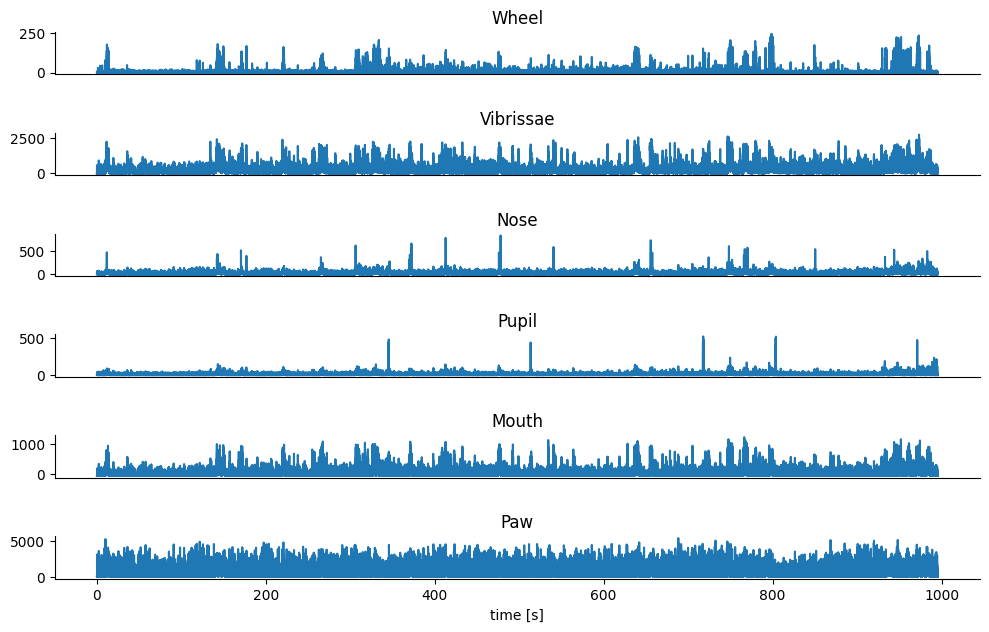

In [28]:
end_behavior0 = len(Behavior[0]['motion'][1]) / camara_sampling_rate
tv_behavior0 = np.arange(0, end_behavior0, 1 / camara_sampling_rate)
plt.figure(figsize=(10,7))
for i in range(1,7):
    plt.subplot(7,1,i)
    plt.plot(tv_behavior0, Behavior[0]['motion'][i])
    plt.title(ROI_names[i-1])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if i < 6:
        plt.xticks([])
plt.xlabel("time [s]")
plt.tight_layout()
plt.show()

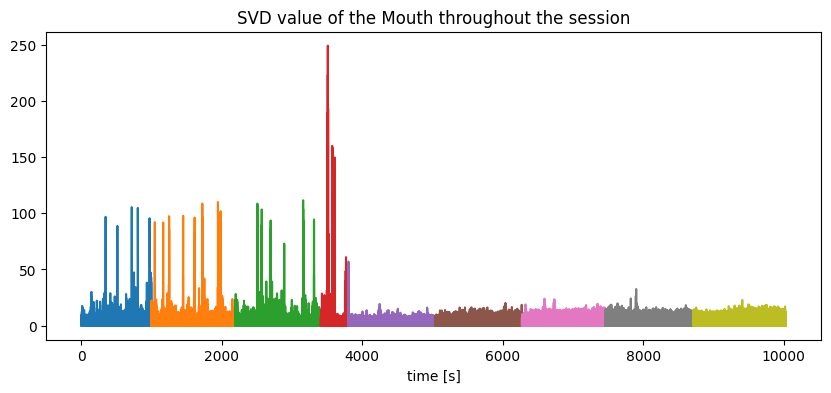

In [29]:
ROI_to_plot = 4

plt.figure(figsize=(10,4))
start = 0
for i in range(n_cam_switch):
    y = Behavior[i]['motion'][ROI_to_plot] / 5
    tv = (np.arange(start, start + len(y)) + 0) / camara_sampling_rate #camera_change_times[i]
    plt.plot(tv, y)

    start += len(y)
    
plt.title(f"SVD value of the {ROI_names[ROI_to_plot]} throughout the session")
plt.xlabel("time [s]")
plt.show()

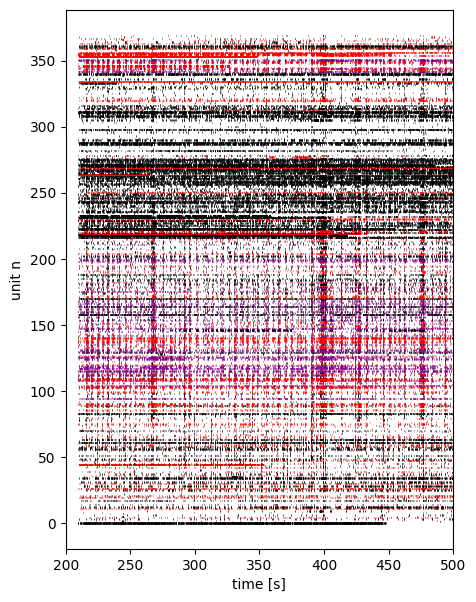

In [106]:
n_spikes = 2000

spikes_to_plot = np.zeros((len(valid_cluster_indx), n_spikes))
for n, n_val in enumerate(valid_cluster_indx): 
    spikes_to_plot[n,:] = spiketimes[n_val][:n_spikes] 

plt.figure(figsize=(5,7))
plt.eventplot(spikes_to_plot, colors=unit_colors, linewidths=0.5)
plt.ylabel("unit n")
plt.xlabel("time [s]")
plt.xlim([200, 500])
plt.show()

## GLM

In [33]:
def get_valid_cluster(Spke_Bundle, SIN_data):
    """
    Gets valid units for GLM study.
    Parameters:
    - Spke_Bundle: Spike bundle dictionary
    - SIN_data: Supposedly inhibitory neuron dictionary

    Returns:
    - valid_cluster_indx: indices where valid_cluster is True
    - cluster_type: Name of each valid cluster (TCA, NW, BW)

    """

    valid_cluster_indx = []
    cluster_type = []

    for neu_indx, GUI_name in enumerate(Spke_Bundle["classif_from_GUI"]["Classification"]):

        if neu_indx in SIN_data["Classif_SIN_indx"]:
            cluster_type.append("NW")
            valid_cluster_indx.append(neu_indx)

        elif neu_indx in SIN_data["Classif_SUR_indx"]:
            cluster_type.append("BW")
            valid_cluster_indx.append(neu_indx)

        elif GUI_name == 'MPW-Axon':
            cluster_type.append("TCA")
            valid_cluster_indx.append(neu_indx)

    return valid_cluster_indx, cluster_type

def get_period_times(Behavior, awake_periods, camera_change_times_duration):
    """    
    Parameters:
    - Behavior: Dictionary with all cam0 files of the day
    - awake_periods: periods to analize (from 0 to n)
    - camera_change_times_duration: time between each cam0 file [seconds] 

    Returns:
    - start_of_period: first time in the period relative to the Spike times [seconds]
    - duration_of_period: duration of the period [seconds] 
    """

    start_of_period = np.zeros(len(awake_periods))
    duration_of_period = np.zeros(len(awake_periods))
    for period in awake_periods:

        duration_of_period[period] = len(Behavior[period]['motion'][1]) / camara_sampling_rate
        start_of_period[period] = start_of_period[period - 1] + duration_of_period[period - 1] + camera_change_times_duration[period]
    
    return start_of_period, duration_of_period

def get_spike_counts(spike_times, start = 0, duration = 1000, time_bin_width = 0.005, GLM_type = "binary_binary"):
    """
    Gets a matrix of n_units x period_time aligned to the start of the period with the spike counts for fixed windows.
    
    Parameters:
    - spike_times: List of lenght n_units containing a list of the spike times
    - start: first time in the period relative to the Spike times [seconds]
    - duration: duration of the period [seconds] 
    - time_bin_width: width of the time bin (step size)

    Returns:
    - tv: time vector
    - binary_st: Matrix of binarized spikes n_units x time
    """

    tv = np.arange(0, duration, time_bin_width)
    binary_st = np.zeros((len(spike_times), len(tv)))
    for n in range(len(spike_times)):

        aligned_spike_times = np.array(spike_times[n]) - start
        all_spikes_indx = aligned_spike_times // time_bin_width
        indx = all_spikes_indx[(all_spikes_indx > 0) & 
                               (all_spikes_indx < len(tv))].astype("uint64")
        if GLM_type == "binary_binary":
            binary_st[n, indx] = 1
        else:
            for i in indx:
                binary_st[n, i] += 1 
    
    return tv, binary_st

def get_binary_behavior(B, thresholds=[]):
    """
    Turns a SVd matrix to a binary matrix (move or not move) given a threshold
    
    Parameters:
    - B: Matrix of SVd's shape time x n_ROIs
    - thresholds: Threshold for each ROI, 
        if non given the function calculates the mean plus two standard deviations 

    Returns:
    - Binarization of the behavior, shape time x n_ROIs
    """

    if not thresholds:
        thresholds = np.mean(B, axis = 0) + 2 * np.std(B, axis = 0)
    
    return np.where(B < thresholds, 0, 1)

def GLM(behavior_array, spike_counts, valid_cluster_indx, GLM_type, thresholds = []):
    """
    Fits a Generalized Linear Model (GLM).
    
    Parameters:
    - behavior_array: Regressors (behavioral responses), shape: time x number_of_regressors.
    - spike_counts: Outcome variable (neural responses), shape: n_neurons x time.
    - valid_cluster_indx: units in which a GLM will be fitted
    - GLM_type: "binary_binary": binary behavior to binary neural responses.
                "continious_binary": continious behavior to binary neural responses.
                "binary_continious": binary behavior to continious neural responses.
                "continious_continious": continious behavior to continious neural responses.
    - thresholds: thresholds for binary behavior

    Returns:
    - GLM_coefs: array of GLM coeffitiens, shape n_neurons x number_of_regressors.
    """
    GLM_coefs = np.zeros((len(valid_cluster_indx), behavior_array.shape[1]))

    if GLM_type == "binary_binary":
        clf = linear_model.LogisticRegression()
        X = get_binary_behavior(behavior_array, thresholds)
        y = np.where(spike_counts >= 1, 1, 0)  

    elif GLM_type == "continious_binary":
        clf = linear_model.LogisticRegression()
        X = behavior_array
        y = np.where(spike_counts >= 1, 1, 0) 
        
    elif GLM_type == "continious_continious":
        clf = linear_model.PoissonRegressor()
        X = behavior_array
        y = spike_counts

    for n, n_val in enumerate(valid_cluster_indx):   
        clf.fit(X, y[n_val])
        GLM_coefs[n, :] = clf.coef_

    return GLM_coefs


In [14]:
## Main GLM pipeline

# Parameters
GLM_type = "binary_binary"
awake_periods = [0, 1, 2]
thresholds = [100, 1200, 200, 200, 500, 4200]

# Get valid units and unit type
valid_cluster_indx, cluster_type = get_valid_cluster(Spke_Bundle, SIN_data)
unit_colors = ["purple" if type == "TCA" 
               else "red" if type == "NW" 
               else "black" for type in cluster_type]

# Get times for each valid period in the session
start_behavior, duration_of_period = get_period_times(Behavior, awake_periods, camera_change_times)

# Get spiketrain of each period
spike_counts_all_periods = []
behavior_array = []
for i, period in enumerate(awake_periods):

    _, spike_counts = get_spike_counts(spiketimes, start_behavior[i], duration_of_period[i])
    spike_counts_all_periods.append(spike_counts)

    behavior_array.append(np.array(Behavior[period]['motion'][1:]).T) #0 indx empty

behavior_array = np.concatenate(behavior_array, axis = 0)
spike_counts_all_periods = np.concatenate(spike_counts_all_periods, axis = 1)

# GLM
GLM_coefs = GLM(behavior_array, spike_counts_all_periods,
                valid_cluster_indx, GLM_type, thresholds)


In [ ]:
## Plot functions

def plot_scatter_of_GLM(x, y, colors, ROIs_to_plot):
    plt.scatter(x, y, c = colors, alpha = 0.8, edgecolors="none")

    plt.xlim(-max(abs(min(x)), abs(max(x))), max(abs(min(x)), abs(max(x))))
    plt.ylim(-max(abs(min(y)), abs(max(y))), max(abs(min(y)), abs(max(y))))

    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)

    plt.gca().spines['left'].set_position('zero')
    plt.gca().spines['bottom'].set_position('zero')
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')

    plt.xlabel(f"{ROIs_to_plot[0]} $\\beta$", labelpad=120)
    plt.ylabel(f"{ROIs_to_plot[1]} $\\beta$", labelpad=150)

    plt.show()

def plot_histogram_of_GLM(GLM_coefs, colors, bins = np.array([]), exp = '2023-03-15_11-05-00'):
    colors = np.array(colors)
    if bins.size == 0:
        bins = np.linspace(np.min(GLM_coefs), np.max(GLM_coefs), 20)

    plt.figure(figsize=(6,10))
    for roi in range(n_ROIs):
        for color in np.unique(colors):
            indx =  np.argwhere(colors == color).flatten()
            
            plt.subplot(6, 1, roi + 1)
            plt.hist(GLM_coefs[indx, roi], bins = bins, histtype='step', 
                     stacked=True, fill=False, edgecolor=color, density=True)
            plt.title(ROI_names[roi])

        plt.vlines(0, 0, plt.gca().get_ylim()[1], linestyles="--", color = "black", alpha=0.5)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        if roi < n_ROIs - 1:
            plt.xticks([])
    
    plt.suptitle("Experiment day " + exp[:10])
    plt.xlabel(f"$\\beta$")
    plt.tight_layout()
    plt.show()


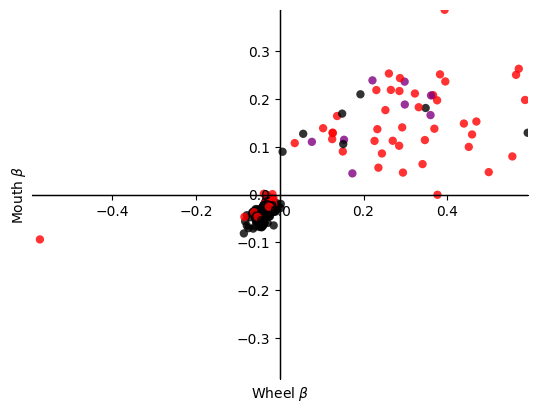

In [31]:
ROIs_to_plot = ["Wheel", "Mouth"]

plot_scatter_of_GLM(GLM_coefs[:, ROI_names.index(ROIs_to_plot[0])],
                    GLM_coefs[:, ROI_names.index(ROIs_to_plot[1])], unit_colors, ROIs_to_plot)

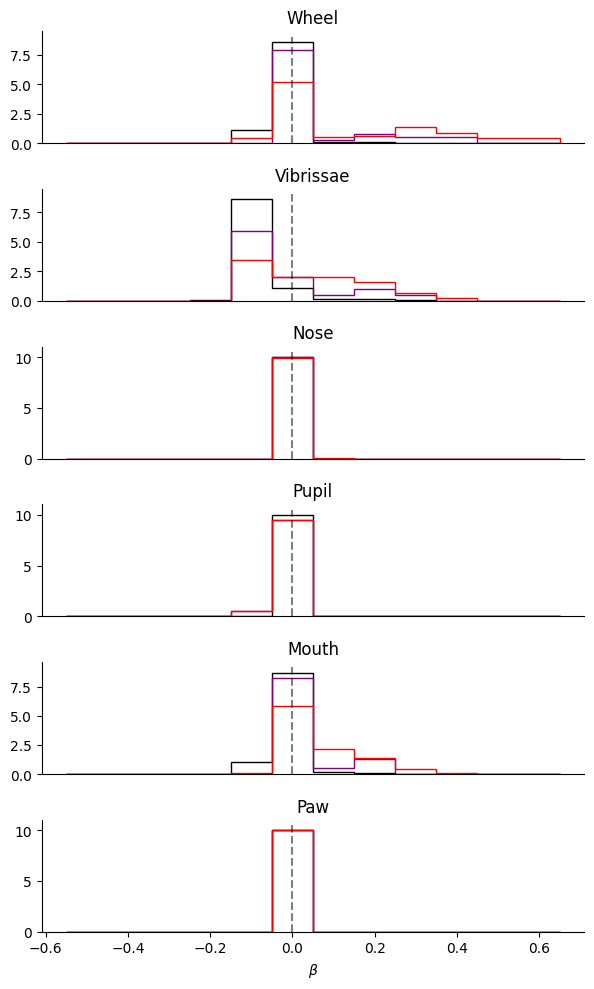

In [27]:
costume_bins = np.arange(-0.55, 0.65, 0.1)
plot_histogram_of_GLM(GLM_coefs, unit_colors, bins = costume_bins)

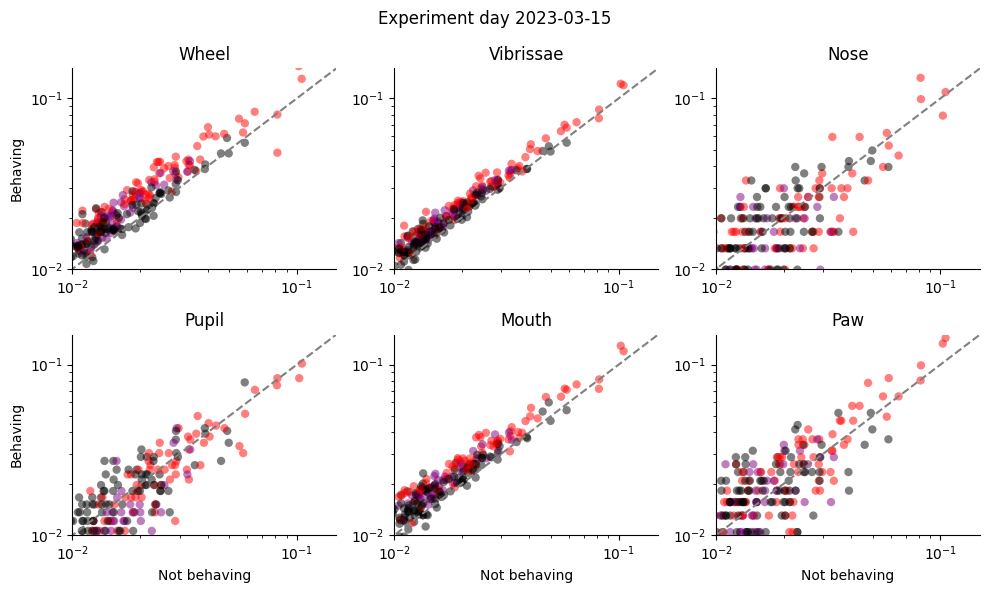

In [ ]:
def plot_activity(behavior_array, spike_counts, colors, ROI_names, exp, thresholds, n_ROIs = 6):
    colors = np.array(colors)
    binary_behavior = get_binary_behavior(behavior_array, thresholds)

    plt.figure(figsize=(10,6))
    for roi in range(n_ROIs):
        
        spike_counts_behavior = np.zeros((spike_counts.shape[0], 2))
        spike_counts_behavior[:, 0] = np.mean(spike_counts[:, binary_behavior[:, roi] == 0], axis = 1)
        spike_counts_behavior[:, 1] = np.mean(spike_counts[:, binary_behavior[:, roi] == 1], axis = 1)

        plt.subplot(2, 3, roi + 1)
        plt.scatter(spike_counts_behavior[:, 0], spike_counts_behavior[:, 1], 
                    edgecolors="none",c=colors, marker="o", alpha=0.5)

        plot_lim = 0.15
        plt.plot([0, plot_lim], [0, plot_lim], linestyle="--", color="gray")
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.xlim([0.01, plot_lim])
        plt.ylim([0.01, plot_lim])
        plt.xscale("log")
        plt.yscale("log")
        if roi in [0, 3]:
            plt.ylabel("Behaving")
        if roi in [3, 4, 5]:
            plt.xlabel("Not behaving")
        plt.title(ROI_names[roi])
        #plt.yticks([])

    plt.suptitle("Experiment day " + exp[:10])
    plt.tight_layout()
    plt.show()

plot_activity(behavior_array, spike_counts_all_periods[valid_cluster_indx, :], unit_colors, ROI_names, example_exp_name, thresholds)


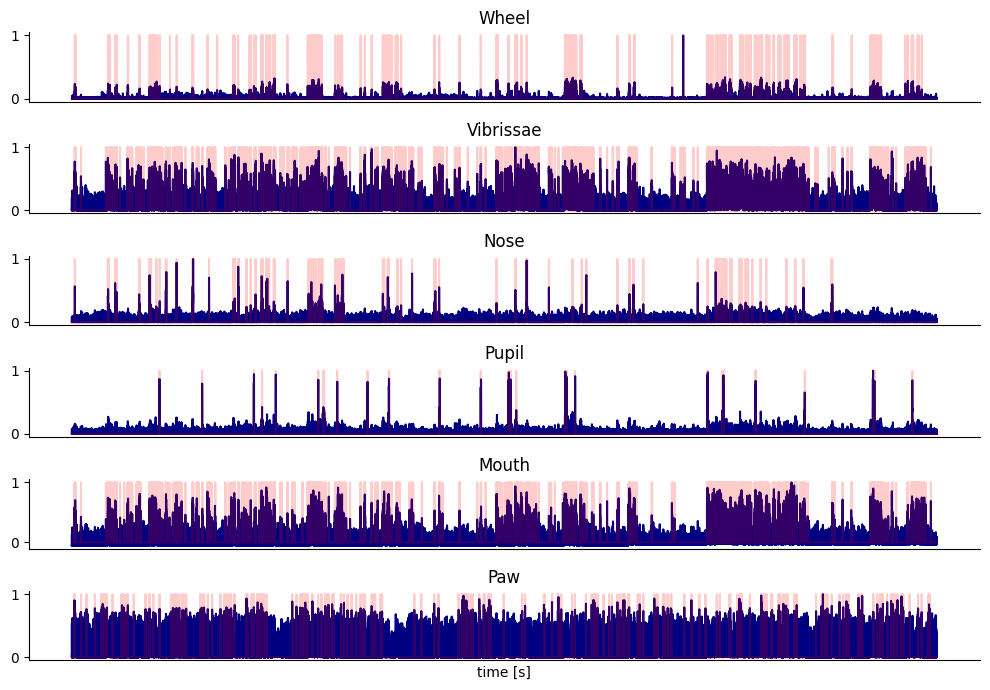

In [ ]:
#plot_SDV_thresholds

thresholds = [100, 1200, 200, 200, 500, 4200]
binary_behavior = get_binary_behavior(behavior_array, thresholds)

plt.figure(figsize=(10,7))
for roi in range(n_ROIs):
    plt.subplot(6, 1, roi+1)
    plt.plot(behavior_array[:, roi] / np.max(behavior_array[:, roi]), color="navy")
    plt.plot(binary_behavior[:, roi], color="red", alpha=0.2)
    #pop_mean = np.mean(spike_counts_all_periods, axis = 0)
    #plt.plot(pop_mean / np.max(pop_mean), color = "orange")
    plt.title(ROI_names[roi])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if roi < 6:
        plt.xticks([])
plt.xlabel("time [s]")
plt.tight_layout()
plt.show()


(array([  1.,   3., 269.,  41.,   2.,  14.,  11.,  16.,   9.,   4.]),
 array([-0.64959478, -0.46879693, -0.28799907, -0.10720121,  0.07359664,
         0.2543945 ,  0.43519235,  0.61599021,  0.79678807,  0.97758592,
         1.15838378]),
 <BarContainer object of 10 artists>)

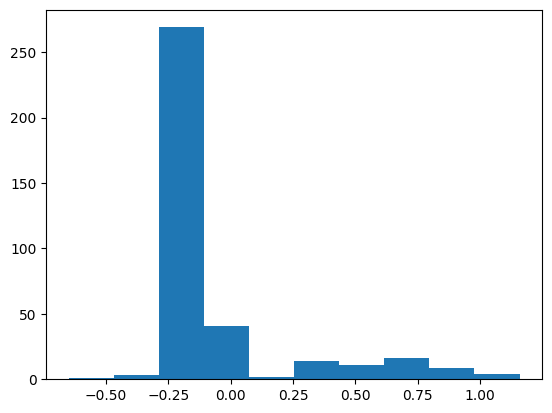

In [107]:
plt.hist(np.sum(GLM_coefs, axis = 1))

In [ ]:

for cam_i, cam in enumerate(Behavior):    

    # Prompt the user 
    periods = input("Valid periods (from-to): ")
    valid_periods[cam_files[cam_i]] = np.arange(int(periods[0]), int(periods[2]))


## Validation

In [19]:
# Cam

path_2_cam =  \
    os.path.join(working_dir, 'events', 
                 example_exp_name,
                 'Sync_cam.npy')

Syn_cam = \
    np.load(path_2_cam,allow_pickle=True,encoding='latin1')

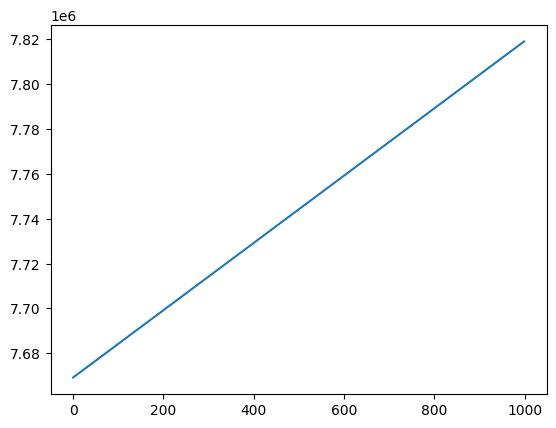

In [20]:
plt.plot(Spke_Bundle["Synchronization_TTLs"]["Sync_cam"][:1000])
#plt.ylim([0,400])

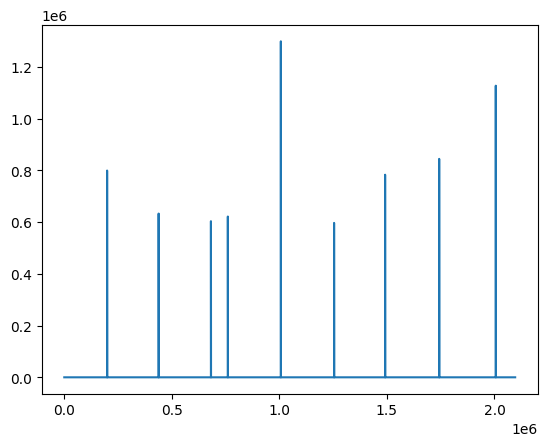

In [21]:
diff_TTLs = np.diff(Spke_Bundle["Synchronization_TTLs"]["Sync_cam"])
plt.plot(diff_TTLs)
#plt.ylim([0,400])

In [22]:
camera_change_times = np.argwhere(diff_TTLs > 1000)
camera_change_times = np.insert(camera_change_times, 0, 0)
rel_camera_change_times = np.diff(camera_change_times)
n_cam_switch = 9
for i in range(n_cam_switch):
    print(f"camera change in TTLs: {rel_camera_change_times[i]}, "
        f"camera change in cam0 file: {len(Behavior[i]['motion'][ROI_to_plot])}")

camera change in TTLs: 199157, camera change in cam0 file: 199158
camera change in TTLs: 239573, camera change in cam0 file: 239573
camera change in TTLs: 243057, camera change in cam0 file: 243057
camera change in TTLs: 78659, camera change in cam0 file: 78659
camera change in TTLs: 246379, camera change in cam0 file: 246379
camera change in TTLs: 247487, camera change in cam0 file: 247487
camera change in TTLs: 237194, camera change in cam0 file: 237194
camera change in TTLs: 251359, camera change in cam0 file: 251359
camera change in TTLs: 263138, camera change in cam0 file: 263138
